# Calculate a nucleation time distribution from a given length distribution
These calculations are used to generate some of the figures in [A. Fang, M. Haataja, “Modeling and Analysis of Electrodeposition in Porous Templates”, Journal of the Electrochemical Society, 164 (13) D875-D887 (2017)](https://altafangcom.files.wordpress.com/2016/12/fang_haataja_jes2017.pdf). 

In [36]:
# Python 2.7

%matplotlib inline

import numpy
from matplotlib import pyplot
import scipy.integrate

First, define some helpful functions.

In [51]:
def g(x, t_eval):
    """Transformation function g(x, t_eval). Here, t_eval is actually t_eval/t_c."""
    return 1. - numpy.sqrt(1. - (t_eval - x))

def dgdx(x, t_eval):
    return -0.5/numpy.sqrt(1. - (t_eval - x))

def ginv(y, t_eval):
    return t_eval - (1. - (y - 1.)**2)

def t_of_d(doverL):
    """Computes (t - t_nucl)/t_c as a function of d/L."""
    return 1. - (doverL - 1.)**2

def f_normal(y, mu, sigma):
    """Normal distribution"""
    return 1./numpy.sqrt(2.*sigma**2*numpy.pi)*numpy.exp(-(y - mu)**2/(2.*sigma**2))

def f_bimodal(y, mu1, sigma1, mu2, sigma2, p):
    """Bimodal distribution (here, a mixture of two Gaussians"""
    return p*f_normal(y, mu1, sigma1) + (1 - p)*f_normal(y, mu2, sigma2)

def f_X(x, f_Y, t_eval, *args, **kwds):
    return f_Y(g(x, t_eval), *args)*numpy.abs(dgdx(x, t_eval))

def calc_FWHM(domain, f_vals):
    """Extract the full width half max of the larger peak.
    (this assumes the peaks won't interfere with each other)"""
    max_f = numpy.max(f_vals)
    whereabovehalf = numpy.where(f_vals >= max_f/2.)[0]
    fwhm = domain[whereabovehalf[-1]] - domain[whereabovehalf[0]]
    return fwhm

Next, input the parameters for the input nanowire length distribution, and plot it. Below, ```y = d/L``` and ```x = t_nucl/t_c```.

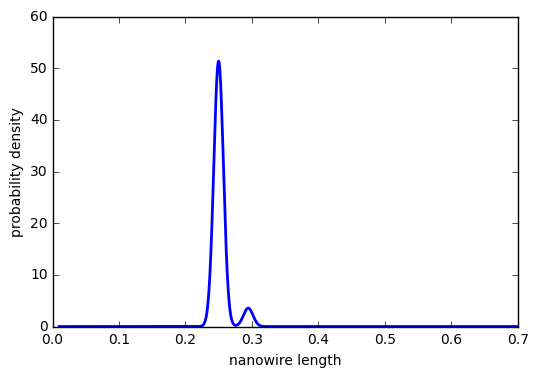

FWHM of y = 0.0170447044704


In [53]:
# Define mu1, sigma1, mu2, sigma2, p. 
# These values came from analysis of the experimental image. 
# You can change these depending on the distribution you want to analyze.
mu1 = 0.2500512
sigma1 = (5.273971e-05)**0.5
mu2 = 0.2946272 
sigma2 = (5.273971e-05)**0.5
p = 0.93516783

# Define the domain of normalized lengths (y values)
ys = numpy.linspace(0.01, 0.7, 10000)

# Plot the input distribution g(y)
f_Y_vals = f_bimodal(ys, mu1, sigma1, mu2, sigma2, p)
pyplot.plot(ys, f_Y_vals, linewidth=2)
pyplot.xlabel("nanowire length")
pyplot.ylabel("probability density")
pyplot.show()

# Extract the full width half max of larger peak. 
fwhm_y = calc_FWHM(ys, f_Y_vals)
print "FWHM of y =", fwhm_y

t_eval/t_c =  0.536914237382


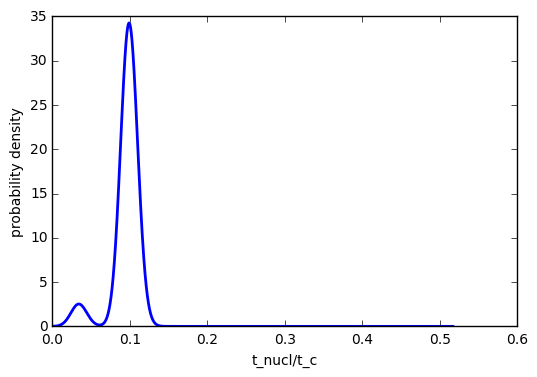

In [47]:
# Calculate appropriate t_eval/t_c -- when probability density of nanowire > threshhold
threshhold = 1.e-2 # Tunable parameter
whereabovethresh = numpy.where(f_Y_vals >= threshhold)[0][-1]
# Calculate corresponding time
t_eval = t_of_d(ys[whereabovethresh])
print "t_eval/t_c = ", t_eval
xs = ginv(ys, t_eval)[::-1] # put xs in increasing order

# Plot the backed-out f(x)
f_X_vals = f_X(xs, f_bimodal, t_eval, mu1, sigma1, mu2, sigma2, p)
pyplot.plot(xs, f_X_vals, linewidth=2)
pyplot.xlabel("t_nucl/t_c")
pyplot.ylabel("probability density")
pyplot.xlim(xmin=0.)
pyplot.show()

 FWHM of x = 0.0255633235421


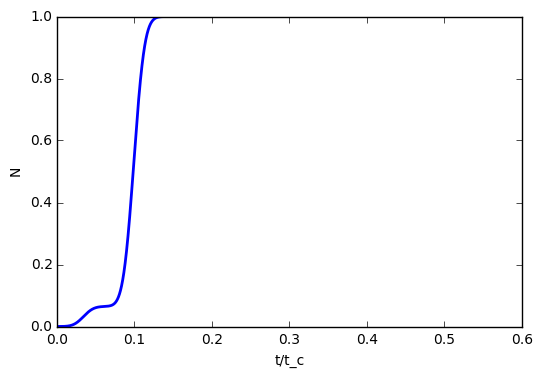

In [55]:
# Extract the full width half max of larger peak. 
fwhm_x = calc_FWHM(xs, f_X_vals)
print "FWHM of x =", fwhm_x

# Numerically integrate to get N(t)
N_of_t = scipy.integrate.cumtrapz(f_X_vals, x=xs, initial=0.)

pyplot.plot(xs, N_of_t, linewidth=2)
pyplot.xlabel("t/t_c")
pyplot.ylabel("N")
pyplot.xlim(xmin=0.)
pyplot.show()

In [40]:
# Save text files for input into gnuplot
numpy.savetxt("nanowire_length_distribution.txt", numpy.column_stack((ys, f_Y_vals)))
numpy.savetxt("nucleation_delay_distribution.txt", numpy.column_stack((xs, f_X_vals)))
numpy.savetxt("N_vs_t.txt", numpy.column_stack((xs, N_of_t)))